Submission with the macro.csv. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import preprocessing, model_selection
%matplotlib inline

color = sns.color_palette()
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
#macro_df = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
#train_df = pd.merge(train_df, macro_df, how = 'left', on = "timestamp")
#test_df = pd.merge(test_df, macro_df, how = 'left, on = "timestamp")
print(train_df.shape , test_df.shape)



(30471, 292) (7662, 291)


In [2]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit
print(train_df.shape , test_df.shape)

(30471, 292) (7662, 291)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [3]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type


sub_area


culture_objects_top_25
thermal_power_plant_raion


incineration_raion
oil_chemistry_raion


radiation_raion
railroad_terminal_raion


big_market_raion


nuclear_reactor_raion
detention_facility_raion


water_1line
big_road1_1line


railroad_1line
ecology


In [4]:
train_df["null_count"] = train_df.isnull().sum(axis=1)
test_df["null_count"] = test_df.isnull().sum(axis=1)

In [5]:
train_df.fillna(-99, inplace=True)
test_df.fillna(-99, inplace=True)

In [6]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year


In [7]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year



In [9]:
# implementing xgboost to check importance of each variable
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
test_X = test_df.drop(["id" , "timestamp"], axis =1)



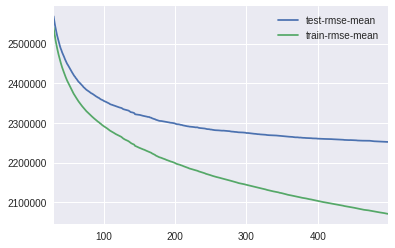

In [10]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_X, label = train_y)
dtest = xgb.DMatrix(test_X)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [11]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(train_X, train_y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
xgb_preds = model_xgb.predict(test_X)

In [13]:
solution = pd.DataFrame({"id":test_df.id, "price_doc":xgb_preds})
solution.to_csv("pred_sol.csv", index = False)

In [14]:
solution.shape

(7662, 2)